# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch
from etnn.tools.training_tools import EpochControl, ConfigStore, AccuracyManager, seeding_all

In [2]:
import numpy as np
import pandas as pd
import os

## Parameter definition

In [3]:
NUM_GONDOLAS = 10
NUM_PART_PG = 5
DATASET_SIZE = 10_000
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
test_perc = 0.2

In [5]:
SAVING_PATH = "."
MODEL_SAVING_NAME = "model.pt"

In [6]:
CONFIG_SAVING_NAME = "config.json"
ACCURACY_SAVING_NAME = "accuracies.csv"
RESULTS_FOLDER = "."

In [7]:
# todo: take care of None values as representing not yet implemented features
config = ConfigStore(
    in_dim=15,
    hidden_dim=32,
    out_dim=1,
    k=2,
    is_accuracy_score=False,
    which_score=None,
    loss_name=None,
    optimizer_name=None,
    num_max_epochs=20,
    learning_rate=0.001,
    batch_size=32,
    early_stop_tol=5,
    is_classification=False
)

## data preparation

In [8]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=NUM_GONDOLAS,
    num_part_pg=NUM_PART_PG,
    num_to_generate=DATASET_SIZE,
    dataset_path=DATASET_PATH
)

In [9]:
len(dataset)

10000

In [10]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [11]:
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)

In [12]:
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [13]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", NUM_PART_PG)])
        for _ in range(NUM_GONDOLAS)
    ]
)

## Define device

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
device = 'cpu'

In [16]:
device

'cpu'

## Set seeds for reproducibility

In [17]:
seeding_all(420)

## Define Model

In [18]:
model = LayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

## Define Loss and Optimizers

In [19]:
criterion = nn.MSELoss()

In [20]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

## Training

In [21]:
# init loss history
loss_history_train = []
loss_history_test = []

In [22]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=SAVING_PATH,
    tolerance=config.early_stop_tol,
    is_accuracy_score=config.is_accuracy_score
)

In [23]:
accuracy_protocoller = AccuracyManager(
    storage_name=ACCURACY_SAVING_NAME,
    storage_path=RESULTS_FOLDER,
    is_classification=False
)

In [24]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    mean_train_loss, train_true_y, train_pred_y = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    loss_history_train += [mean_train_loss]

    mean_test_loss, test_true_y, test_pred_y = eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )
    loss_history_test += [mean_test_loss]

    # use accuracy manager to calc accuracy metrics and save them
    accuracy_protocoller.calc_and_collect(
        config_id="t1",
        epoch=epoch+1,
        train_y_true=train_true_y,
        train_y_pred=train_pred_y,
        train_loss=mean_train_loss,
        test_y_true=test_true_y,
        test_y_pred=test_pred_y,
        test_loss=mean_test_loss,
    )

    # check if model is better and save it
    if epoch_control.retain_best_and_stop(model, mean_train_loss, mean_test_loss, config):
        break

  5%|▌         | 1/20 [00:06<02:01,  6.38s/it]

++save++


 15%|█▌        | 3/20 [00:19<01:49,  6.46s/it]

++save++


 30%|███       | 6/20 [00:39<01:32,  6.61s/it]

++save++


 55%|█████▌    | 11/20 [01:18<01:04,  7.17s/it]


In [25]:
df_measures = pd.read_csv(os.path.join(SAVING_PATH, ACCURACY_SAVING_NAME))
df_measures

,config_id,epoch,train_loss,val_loss,test_loss,train_mse,train_msa,train_explained_variance,train_r2,val_mse,val_msa,val_explained_variance,val_r2,test_mse,test_msa,test_explained_variance,test_r2
0,t1,1,633.264099,0.0,37.157944,633.936157,10.434734,-19.894468,-19.927076,0.0,0.0,0.0,0.0,37.220943,4.880239,-0.221605,-0.247702
1,t1,2,40.020794,0.0,38.548046,39.998463,5.066658,-0.320199,-0.320403,0.0,0.0,0.0,0.0,38.639553,4.904961,-0.187778,-0.295255
2,t1,3,41.352055,0.0,35.782757,41.353500,5.159584,-0.364999,-0.365134,0.0,0.0,0.0,0.0,35.861015,4.761080,-0.196226,-0.202115
3,t1,4,41.300411,0.0,36.488838,41.295254,5.143546,-0.362856,-0.363211,0.0,0.0,0.0,0.0,36.564304,4.824800,-0.196650,-0.225690
4,t1,5,40.091259,0.0,45.639965,40.086823,5.068061,-0.322992,-0.323319,0.0,0.0,0.0,0.0,45.700794,5.510725,-0.206098,-0.531959
5,t1,6,42.573845,0.0,35.453419,42.563240,5.223276,-0.404980,-0.405069,0.0,0.0,0.0,0.0,35.537445,4.716263,-0.186001,-0.191268
6,t1,7,43.042141,0.0,45.142570,43.056419,5.273295,-0.421021,-0.421350,0.0,0.0,0.0,0.0,45.244213,5.305459,-0.170969,-0.516654
7,t1,8,41.004566,0.0,39.234829,40.981853,5.099648,-0.352472,-0.352866,0.0,0.0,0.0,0.0,39.332008,4.936762,-0.175849,-0.318468
8,t1,9,41.255173,0.0,39.992195,41.252628,5.136293,-0.361618,-0.361804,0.0,0.0,0.0,0.0,40.089802,4.982496,-0.174087,-0.343870
9,t1,10,39.716881,0.0,35.720409,39.729553,5.034967,-0.311191,-0.311525,0.0,0.0,0.0,0.0,35.810677,4.723145,-0.179913,-0.200427


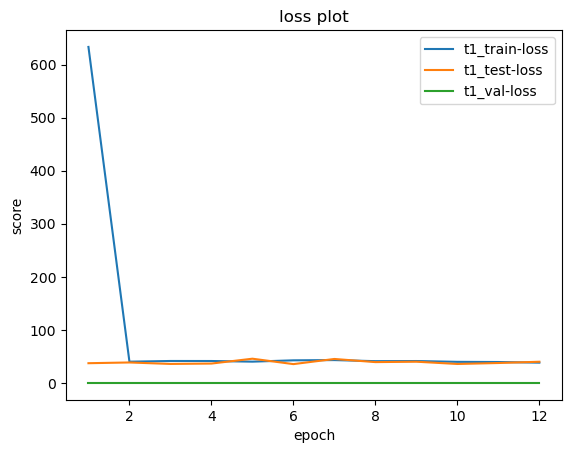

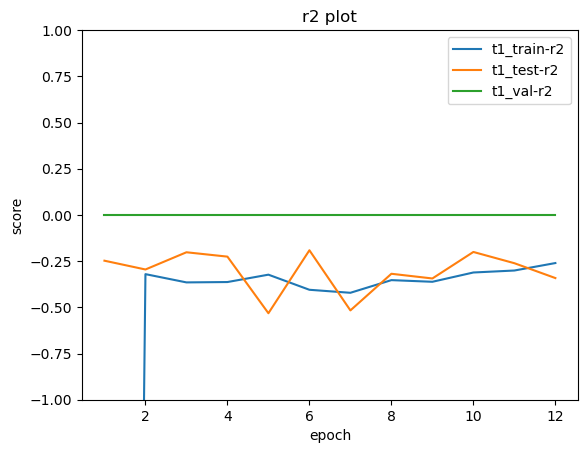

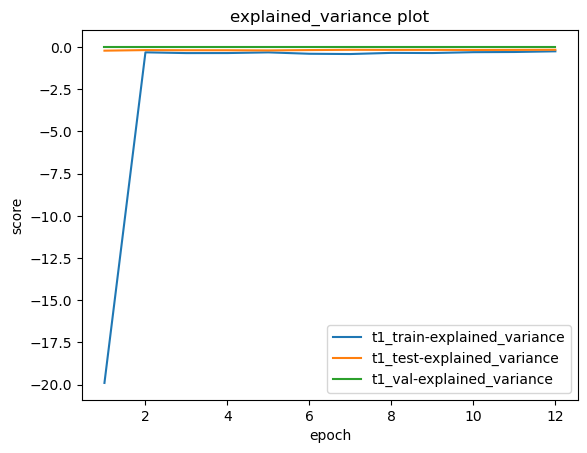

In [26]:
for what in ['loss', 'r2', 'explained_variance']:
    plt.figure()
    for config_id in df_measures.config_id.unique():
        # make subdataset for config id
        sub_df = df_measures[df_measures.config_id == config_id]

        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == 'r2':
        plt.ylim(-1,1)
    plt.legend()
    plt.show()

In [27]:
# plot explained variances

In [28]:
# plot r2

In [29]:
test_loss = torch.nn.CrossEntropyLoss()

In [30]:
label = torch.tensor([0., 1.,2.,3.,4.])
pred = torch.tensor([1.1, 1., 2., 2., 4.])

In [31]:
test_loss(pred, label)

tensor(16.1880)

todo:
- build option for classification instead of regression
- either still predict number or make softmax classification

## Test/Debug

with open("test1.txt", "w") as file:
    file.write("config_id, epoch\n")
    file.write("0,1")

with open("test1.txt", "a") as file:
    file.write(f"\n")

import pandas as pd

pd.read_csv("test1.txt")

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()